In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 25.9 MB/s eta 0:00:00


In [3]:
# ======================
# INTENT-ONLY MODEL SETUP
# ======================

import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from pathlib import Path
from typing import List, Dict, Tuple
from sklearn.metrics import precision_recall_fscore_support, f1_score
import matplotlib.pyplot as plt
import re
import emoji

# Model configuration
MODEL_NAME = "vinai/phobert-base"
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 50
LR = 5e-5
WEIGHT_DECAY = 0.01
SEED = 64
DROPOUT = 0.1

# Set random seed
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {DEVICE}")



Using device: cuda


In [4]:
# Load data
DATA_DIR = "/content/drive/MyDrive/dataset/vped/train"
DEV_DIR = "/content/drive/MyDrive/dataset/vped/dev"
TEST_DIR = "/content/drive/MyDrive/dataset/vped/test"

In [5]:
# ================================
# LOAD LABEL SCHEMA
# ================================

def load_labels_from_file(file_path: str) -> List[str]:
    """Load labels from text file (one label per line)"""
    labels = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith("#"):
                labels.append(line)
    return labels

# Load intent labels
INTENT_LABEL_FILE = "/content/drive/MyDrive/dataset/vped/intent_label.txt"
INTENT_LABELS = load_labels_from_file(INTENT_LABEL_FILE)

# Create mappings
INTENT2ID = {intent: i for i, intent in enumerate(INTENT_LABELS)}
ID2INTENT = {i: intent for intent, i in INTENT2ID.items()}

print(f"📋 Intent Labels ({len(INTENT_LABELS)}): {INTENT_LABELS}")
print(f"Intent mappings: {INTENT2ID}")

📋 Intent Labels (5): ['add_expense', 'update_expense', 'delete_expense', 'search_expense', 'stat_expense']
Intent mappings: {'add_expense': 0, 'update_expense': 1, 'delete_expense': 2, 'search_expense': 3, 'stat_expense': 4}


In [6]:
# =================
# INTENT MODEL CLASSES
# =================

class MultiIntentClassifier(nn.Module):
    """Multi-label intent classifier với sigmoid activation"""
    def __init__(self, input_dim, num_intent_labels, dropout_rate=0.1):
        super(MultiIntentClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, num_intent_labels)
        self.sigmoid = nn.Sigmoid()
        self.reset_params()

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear(x)
        return self.sigmoid(x)

    def reset_params(self):
        nn.init.uniform_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

class IntentModel(nn.Module):
    def __init__(self, model_name, num_intents, dropout=0.1):
        super().__init__()

        # PhoBERT encoder
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        # Chỉ có Multi-Intent Classifier
        self.multi_intent_classifier = MultiIntentClassifier(hidden_size, num_intents, dropout)

    def forward(self, input_ids, attention_mask, token_type_ids=None, intent_label_ids=None):
        # Encode với PhoBERT
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [batch, hidden] -> h_cls

        # Intent classification
        intent_logits = self.multi_intent_classifier(pooled_output)  # [batch, num_intents]

        total_loss = 0
        if intent_label_ids is not None:
            intent_loss_fct = nn.BCELoss()
            intent_loss = intent_loss_fct(intent_logits + 1e-10, intent_label_ids)
            total_loss = intent_loss

        return {
            "total_loss": total_loss,
            "intent_logits": intent_logits
        }

print("✅ Intent model classes defined!")

✅ Intent model classes defined!


In [7]:
# =================
# INTENT DATASET CLASS
# =================

class IntentDataset(Dataset):
    """Dataset chỉ cho intent classification"""
    def __init__(self, sentences, utterance_intents, tokenizer, max_len=128):
        self.sentences = sentences
        self.utterance_intents = utterance_intents
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.num_intents = len(INTENT_LABELS)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.sentences[idx]
        utt_intents = self.utterance_intents[idx]

        # Subword tokenization
        subword_tokens = []
        for token in tokens:
            pieces = self.tokenizer.tokenize(token) or [self.tokenizer.unk_token]
            subword_tokens.extend(pieces)

        # Convert to input IDs
        input_ids = self.tokenizer.convert_tokens_to_ids(subword_tokens)
        input_ids = self.tokenizer.build_inputs_with_special_tokens(input_ids)

        attention_mask = [1] * len(input_ids)
        token_type_ids = [0] * len(input_ids)

        # Truncate if necessary
        if len(input_ids) > self.max_len:
            input_ids = input_ids[:self.max_len]
            attention_mask = attention_mask[:self.max_len]
            token_type_ids = token_type_ids[:self.max_len]

        # Pad to max_len
        pad_len = self.max_len - len(input_ids)
        if pad_len > 0:
            pad_id = self.tokenizer.pad_token_id
            input_ids.extend([pad_id] * pad_len)
            attention_mask.extend([0] * pad_len)
            token_type_ids.extend([0] * pad_len)

        # Intent vector (multi-hot)
        utt_intent_vector = torch.zeros(self.num_intents, dtype=torch.float)
        for intent in utt_intents:
            if intent in INTENT2ID:
                utt_intent_vector[INTENT2ID[intent]] = 1.0

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "intent_labels": utt_intent_vector
        }

def intent_collate_fn(batch):
    """Collate function cho intent-only dataset"""
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "token_type_ids": torch.stack([item["token_type_ids"] for item in batch]),
        "intent_labels": torch.stack([item["intent_labels"] for item in batch])
    }

print("✅ Intent dataset class defined!")

✅ Intent dataset class defined!


In [8]:
# =================
# DATA LOADING FUNCTIONS
# =================

def read_lines(file_path: Path) -> List[str]:
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.rstrip("\n") for line in f]

def resolve_file(base_dir: Path, name: str) -> Path:
    candidates = [base_dir / name, base_dir / f"{name}.txt"]
    for path in candidates:
        if path.exists():
            return path
    raise FileNotFoundError(f"Cannot find {name}(.txt) in {base_dir}")

def remove_emoji(text: str) -> str:
    """
    Loại bỏ emoji/icon khỏi text, thay bằng khoảng trắng
    """
    # Cách 1: dùng thư viện emoji (ổn định hơn)
    text = emoji.replace_emoji(text, replace=' ')

    # Cách 2: fallback nếu còn sót ký tự lạ
    text = re.sub(r'[^\w\s.,?!@#%:/_-]', ' ', text)

    # chuẩn hóa khoảng trắng
    return re.sub(r'\s+', ' ', text).strip()

def load_intent_data(data_dir: str) -> Tuple[List[List[str]], List[List[str]]]:
    """
    Load chỉ intent data từ các file, có tích hợp bước lọc emoji.
    """
    base = Path(data_dir)

    seq_in_path = resolve_file(base, "seq_in")
    label_path = resolve_file(base, "label")

    seq_in_lines = read_lines(seq_in_path)
    label_lines = read_lines(label_path)

    n = len(seq_in_lines)
    assert len(label_lines) == n

    sentences = []
    utterance_intents = []

    for i in range(n):
        raw_line = seq_in_lines[i].strip()

        # 🧹 Bước mới: loại bỏ emoji/icon trước khi split
        cleaned_line = remove_emoji(raw_line)

        # giữ đúng dạng tokenized input (đã segment)
        tokens = cleaned_line.split()
        sentences.append(tokens)

        # xử lý intent
        label_line = label_lines[i].strip()
        if label_line == "":
            utterance_intents.append(["none"])
        else:
            utterance_intents.append(label_line.split("#"))

    print(f"Loaded {n} examples from {data_dir} (emoji removed)")
    return sentences, utterance_intents

# Load data
DATA_DIR = "/content/drive/MyDrive/dataset/vped/train"
DEV_DIR = "/content/drive/MyDrive/dataset/vped/dev"
TEST_DIR = "/content/drive/MyDrive/dataset/vped/test"

train_sentences, train_intents = load_intent_data(DATA_DIR)
dev_sentences, dev_intents = load_intent_data(DEV_DIR)
test_sentences, test_intents = load_intent_data(TEST_DIR)

print(f"Train: {len(train_sentences)} examples")
print(f"Dev: {len(dev_sentences)} examples")
print(f"Test: {len(test_sentences)} examples")
print(f"Sample: {train_sentences[0]} -> {train_intents[0]}")

Loaded 1014 examples from /content/drive/MyDrive/dataset/vped/train (emoji removed)
Loaded 210 examples from /content/drive/MyDrive/dataset/vped/dev (emoji removed)
Loaded 115 examples from /content/drive/MyDrive/dataset/vped/test (emoji removed)
Train: 1014 examples
Dev: 210 examples
Test: 115 examples
Sample: ['Còn', 'cái', 'viettel', 'đầu', 'năm', 'thì', 'xóa', 'giùm', 'nhóoooo', 'và', 'Them', 'tien', 'do', '40', 'k', 'sang', 'nay'] -> ['add_expense', 'delete_expense']


In [9]:
# =================
# TOKENIZER & DATASET CREATION
# =================

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)
print(f"Tokenizer: {MODEL_NAME}")

# Create datasets
train_dataset = IntentDataset(train_sentences, train_intents, tokenizer, MAX_LEN)
dev_dataset = IntentDataset(dev_sentences, dev_intents, tokenizer, MAX_LEN)
test_dataset = IntentDataset(test_sentences, test_intents, tokenizer, MAX_LEN)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=intent_collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=intent_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=intent_collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Dev batches: {len(dev_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test data loading
sample_batch = next(iter(train_loader))
print(f"Sample batch shapes:")
for key, tensor in sample_batch.items():
    print(f"  {key}: {tensor.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizer: vinai/phobert-base
Train batches: 32
Dev batches: 7
Test batches: 4
Sample batch shapes:
  input_ids: torch.Size([32, 128])
  attention_mask: torch.Size([32, 128])
  token_type_ids: torch.Size([32, 128])
  intent_labels: torch.Size([32, 5])


In [10]:
# =================
# VISUALIZE TOKENIZATION (phiên bản ngắn gọn)
# =================

# Lấy một vài câu mẫu từ train_sentences
sample_sentences = train_sentences[:3]

print("="*80)
print("VISUALIZATION: TOKENIZATION PROCESS")
print("="*80)
print(f"Tokenizer: {MODEL_NAME}")
print(f"Max length: {MAX_LEN}")
print()

for idx, tokens in enumerate(sample_sentences):
    print(f"\n{'='*80}")
    print(f"Example {idx + 1}:")
    print(f"{'='*80}")

    original_text = " ".join(tokens)
    print(f"\n📝 Original: {original_text}")
    print(f"📋 Tokens ({len(tokens)}): {tokens}")

    # Tokenize
    subword_tokens = []
    print(f"\n🔤 Subword tokenization:")
    for token in tokens:
        pieces = tokenizer.tokenize(token) or [tokenizer.unk_token]
        subword_tokens.extend(pieces)
        print(f"   '{token}' → {pieces}")

    print(f"\n   All subwords ({len(subword_tokens)}): {subword_tokens}")

    # Convert to IDs
    input_ids = tokenizer.convert_tokens_to_ids(subword_tokens)
    input_ids_with_special = tokenizer.build_inputs_with_special_tokens(input_ids)

    print(f"\n🔢 Token IDs: {input_ids}")
    print(f"✨ With special tokens ({len(input_ids_with_special)}): {input_ids_with_special}")

    # Decode
    decoded = tokenizer.decode(input_ids_with_special, skip_special_tokens=False)
    print(f"🔄 Decoded: {decoded}")

    # So sánh với dataset
    dataset_item = train_dataset[idx]
    print(f"\n📊 From dataset (first 30 IDs): {dataset_item['input_ids'][:30].tolist()}")
    print()

print("="*80)

VISUALIZATION: TOKENIZATION PROCESS
Tokenizer: vinai/phobert-base
Max length: 128


Example 1:

📝 Original: Còn cái viettel đầu năm thì xóa giùm nhóoooo và Them tien do 40 k sang nay
📋 Tokens (17): ['Còn', 'cái', 'viettel', 'đầu', 'năm', 'thì', 'xóa', 'giùm', 'nhóoooo', 'và', 'Them', 'tien', 'do', '40', 'k', 'sang', 'nay']

🔤 Subword tokenization:
   'Còn' → ['Còn']
   'cái' → ['cái']
   'viettel' → ['viet@@', 'tel']
   'đầu' → ['đầu']
   'năm' → ['năm']
   'thì' → ['thì']
   'xóa' → ['xó@@', 'a']
   'giùm' → ['giùm']
   'nhóoooo' → ['nh@@', 'ó@@', 'oo@@', 'oo']
   'và' → ['và']
   'Them' → ['Th@@', 'em']
   'tien' → ['ti@@', 'en']
   'do' → ['do']
   '40' → ['40']
   'k' → ['k']
   'sang' → ['sang']
   'nay' → ['nay']

   All subwords (24): ['Còn', 'cái', 'viet@@', 'tel', 'đầu', 'năm', 'thì', 'xó@@', 'a', 'giùm', 'nh@@', 'ó@@', 'oo@@', 'oo', 'và', 'Th@@', 'em', 'ti@@', 'en', 'do', '40', 'k', 'sang', 'nay']

🔢 Token IDs: [631, 224, 18808, 12473, 127, 29, 54, 58102, 1517, 20256, 2008, 1

In [11]:
# =================
# MODEL INITIALIZATION
# =================

# Initialize model
model = IntentModel(
    model_name=MODEL_NAME,
    num_intents=len(INTENT_LABELS),
    dropout=DROPOUT
)

model.to(DEVICE)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

# Test forward pass
sample_input = sample_batch["input_ids"][:2].to(DEVICE)
sample_attention = sample_batch["attention_mask"][:2].to(DEVICE)
sample_labels = sample_batch["intent_labels"][:2].to(DEVICE)

with torch.no_grad():
    outputs = model(sample_input, sample_attention, intent_label_ids=sample_labels)
    print(f"Forward pass test:")
    print(f"  Loss: {outputs['total_loss']:.4f}")
    print(f"  Intent logits shape: {outputs['intent_logits'].shape}")

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Model initialized with 135002117 parameters
Forward pass test:
  Loss: 1.2794
  Intent logits shape: torch.Size([2, 5])


In [12]:
# =================
# TRAINING FUNCTIONS
# =================

# Optimizer setup
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': WEIGHT_DECAY
    },
    {
        'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)

# Scheduler
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

def train_epoch():
    """Train một epoch"""
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Move to device
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        # Forward pass
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            intent_label_ids=batch["intent_labels"]
        )

        # Backward pass
        outputs["total_loss"].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += outputs["total_loss"].item()

    return total_loss / len(train_loader)

@torch.no_grad()
def evaluate(loader, mode="dev"):
    """Evaluate model"""
    model.eval()

    total_loss = 0
    all_predictions = []
    all_labels = []

    for batch in loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            intent_label_ids=batch["intent_labels"]
        )

        total_loss += outputs["total_loss"].item()

        # Get predictions
        intent_logits = outputs["intent_logits"]
        predictions = (intent_logits > 0.5).float()

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch["intent_labels"].cpu().numpy())

    # Calculate accuracy
    correct = 0
    total = len(all_predictions)

    for pred, label in zip(all_predictions, all_labels):
        if np.array_equal(pred, label):
            correct += 1

    accuracy = correct / total

    return {
        "loss": total_loss / len(loader),
        "accuracy": accuracy
    }

print("✅ Training functions defined!")

✅ Training functions defined!


In [14]:
# =================
# TRAINING LOOP
# =================

best_val_acc = 0.0
train_losses = []
val_losses = []
val_accuracies = []

print("Starting intent-only training...")
print(f"Total epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LR}")
print("-" * 60)

#/content/drive/MyDrive/CS221/
save_path = Path("/content/drive/MyDrive/CS221/vslim_best")
save_path.mkdir(parents=True, exist_ok=True)

for epoch in range(EPOCHS):
    # Train
    train_loss = train_epoch()

    # Validate
    val_results = evaluate(dev_loader, "dev")

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_results["loss"])
    val_accuracies.append(val_results["accuracy"])

    # Print progress
    print(f"Epoch {epoch+1:2d}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_results['loss']:.4f}")
    print(f"  Val Acc:    {val_results['accuracy']:.4f}")

    # Save best model
    if val_results['accuracy'] > best_val_acc:
        best_val_acc = val_results['accuracy']
        torch.save(model.state_dict(), save_path / "intent_best_model.pt")
        tokenizer.save_pretrained(save_path)

        print(f"  ✓ New best model saved! (Acc: {best_val_acc:.4f})")

    print()

print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")

Starting intent-only training...
Total epochs: 50
Batch size: 32
Learning rate: 5e-05
------------------------------------------------------------
Epoch  1/50
  Train Loss: 0.8363
  Val Loss:   0.4906
  Val Acc:    0.1190
  ✓ New best model saved! (Acc: 0.1190)

Epoch  2/50
  Train Loss: 0.6470
  Val Loss:   0.3094
  Val Acc:    0.5095
  ✓ New best model saved! (Acc: 0.5095)

Epoch  3/50
  Train Loss: 0.4181
  Val Loss:   0.2331
  Val Acc:    0.6810
  ✓ New best model saved! (Acc: 0.6810)

Epoch  4/50
  Train Loss: 0.3335
  Val Loss:   0.1720
  Val Acc:    0.7619
  ✓ New best model saved! (Acc: 0.7619)

Epoch  5/50
  Train Loss: 0.2485
  Val Loss:   0.1174
  Val Acc:    0.8476
  ✓ New best model saved! (Acc: 0.8476)

Epoch  6/50
  Train Loss: 0.1480
  Val Loss:   0.1113
  Val Acc:    0.8619
  ✓ New best model saved! (Acc: 0.8619)

Epoch  7/50
  Train Loss: 0.1115
  Val Loss:   0.1312
  Val Acc:    0.8667
  ✓ New best model saved! (Acc: 0.8667)

Epoch  8/50
  Train Loss: 0.0747
  Val Lo

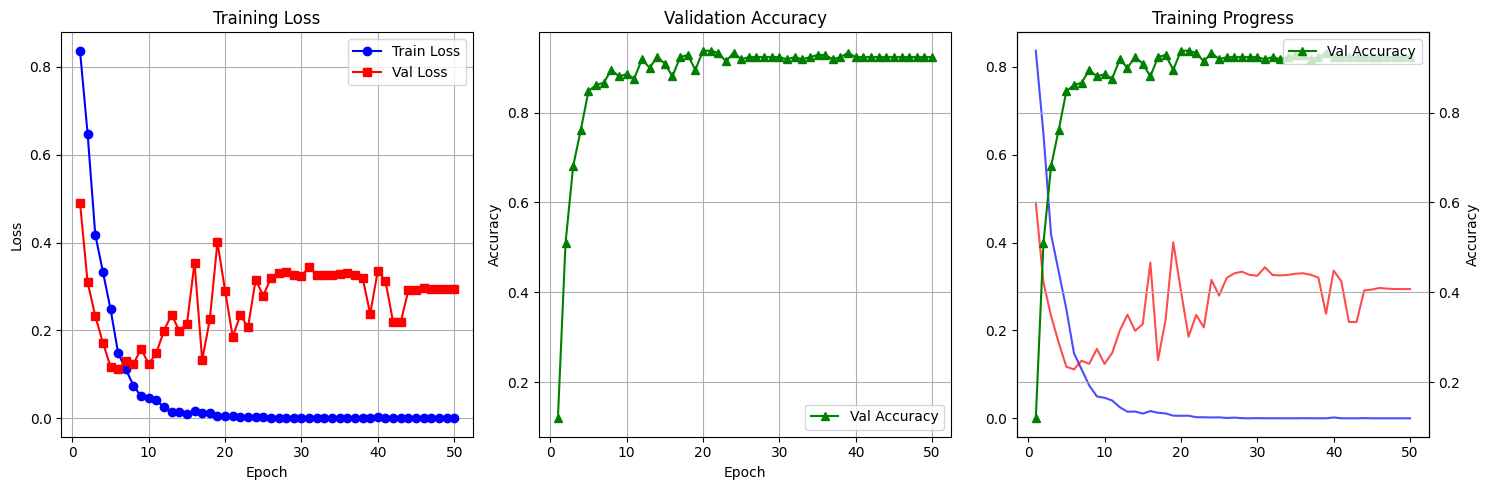

Best validation accuracy: 0.9381


In [15]:
# =================
# TRAINING VISUALIZATION
# =================

plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Val Accuracy', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

# Combined plot
plt.subplot(1, 3, 3)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', alpha=0.7)
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss', alpha=0.7)
plt2 = plt.gca().twinx()
plt2.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Val Accuracy', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt2.set_ylabel('Accuracy')
plt.title('Training Progress')
plt.legend(loc='upper left')
plt2.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {best_val_acc:.4f}")

In [16]:
# =================
# MODEL EVALUATION
# =================

# Load best model
model.load_state_dict(torch.load(save_path / "intent_best_model.pt", map_location=DEVICE))
print("Best model loaded!")

# Evaluate on test set
test_results = evaluate(test_loader, "test")
print(f"Test Results:")
print(f"  Loss: {test_results['loss']:.4f}")
print(f"  Accuracy: {test_results['accuracy']:.4f}")

# Detailed evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"]
        )

        intent_logits = outputs["intent_logits"]
        predictions = (intent_logits > 0.5).float()

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch["intent_labels"].cpu().numpy())

# Calculate per-intent metrics
intent_names = INTENT_LABELS
intent_precision = []
intent_recall = []
intent_f1 = []

for i, intent_name in enumerate(intent_names):
    true_positives = sum(1 for pred, label in zip(all_predictions, all_labels)
                        if pred[i] == 1 and label[i] == 1)
    false_positives = sum(1 for pred, label in zip(all_predictions, all_labels)
                         if pred[i] == 1 and label[i] == 0)
    false_negatives = sum(1 for pred, label in zip(all_predictions, all_labels)
                         if pred[i] == 0 and label[i] == 1)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    intent_precision.append(precision)
    intent_recall.append(recall)
    intent_f1.append(f1)

print("\nPer-Intent Metrics:")
print("-" * 50)
for i, intent_name in enumerate(intent_names):
    print(f"{intent_name:20s}: P={intent_precision[i]:.3f}, R={intent_recall[i]:.3f}, F1={intent_f1[i]:.3f}")

print(f"\nMacro Average:")
print(f"  Precision: {np.mean(intent_precision):.3f}")
print(f"  Recall:    {np.mean(intent_recall):.3f}")
print(f"  F1:        {np.mean(intent_f1):.3f}")

Best model loaded!
Test Results:
  Loss: 0.2892
  Accuracy: 0.8957

Per-Intent Metrics:
--------------------------------------------------
add_expense         : P=0.971, R=0.944, F1=0.958
update_expense      : P=1.000, R=0.941, F1=0.970
delete_expense      : P=0.912, R=0.969, F1=0.939
search_expense      : P=0.900, R=0.871, F1=0.885
stat_expense        : P=1.000, R=0.886, F1=0.939

Macro Average:
  Precision: 0.957
  Recall:    0.922
  F1:        0.938


In [17]:
# =================
# INFERENCE FUNCTION
# =================

def predict_intent(tokens: List[str], threshold: float = 0.5) -> List[str]:
    """Predict intent cho một câu"""
    model.eval()

    with torch.no_grad():
        # Tokenize
        subword_tokens = []
        for token in tokens:
            pieces = tokenizer.tokenize(token) or [tokenizer.unk_token]
            subword_tokens.extend(pieces)

        input_ids = tokenizer.convert_tokens_to_ids(subword_tokens)
        input_ids = tokenizer.build_inputs_with_special_tokens(input_ids)

        # Pad/truncate
        if len(input_ids) > MAX_LEN:
            input_ids = input_ids[:MAX_LEN]

        pad_len = MAX_LEN - len(input_ids)
        if pad_len > 0:
            pad_id = tokenizer.pad_token_id
            input_ids.extend([pad_id] * pad_len)

        attention_mask = [1] * (MAX_LEN - pad_len) + [0] * pad_len
        token_type_ids = [0] * MAX_LEN

        # Convert to tensors
        input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0).to(DEVICE)
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Get predictions
        intent_probs = outputs["intent_logits"][0].cpu().numpy()
        predicted_intents = []

        for i, prob in enumerate(intent_probs):
            if prob >= threshold:
                predicted_intents.append(INTENT_LABELS[i])

        # Fallback
        if not predicted_intents:
            best_idx = np.argmax(intent_probs)
            predicted_intents = [INTENT_LABELS[best_idx]]

        return predicted_intents, intent_probs

def show_prediction(tokens: List[str], predicted_intents: List[str], probs: np.ndarray):
    """Display prediction in a readable format"""
    print("Tokens:       ", " ".join(tokens))
    print("Pred intents: ", predicted_intents)
    print("Probabilities:", [f"{prob:.3f}" for prob in probs])
    print("-" * 60)

print("✅ Inference function ready!")

✅ Inference function ready!


In [18]:
# =================
# DEMO INFERENCE
# =================

# Demo examples
demo_examples = [
    ["Tôi", "vừa", "chi", "2", "triệu", "cho", "ăn_uống"],
    ["Thống_kê", "chi_tiêu", "tháng", "này"],
    ["Tìm", "giao_dịch", "ăn_trưa", "hôm_qua"],
    ["Sửa", "tiền_điện", "tháng_7", "thành", "900", "nghìn"],
    ["Xoá", "giao_dịch", "tại", "Hà_Nội"],
    ["Tôi", "vừa", "giao_dịch", "2", "triệu", ",", "xoá", "giao_dịch", "3", "triệu", "hôm_qua"],
    ["Xoá", "giao_dịch", "tại", "Hà_Nội", ",", "thêm", "3", "triệu", "tiền", "cơm"],
    ["Hoàng", "vừa", "cho", "Đăng", "vay", "2", "triệu"]
]

print("INFERENCE DEMO")
print("="*80)
print(f"Model: {MODEL_NAME}")
print(f"Threshold: 0.5")
print(f"Schema: {len(INTENT_LABELS)} intents")
print("="*80)

for i, tokens in enumerate(demo_examples, 1):
    print(f"\nExample {i}:")
    predicted_intents, probs = predict_intent(tokens, threshold=0.5)
    show_prediction(tokens, predicted_intents, probs)

print("\nDemo completed! ✅")

INFERENCE DEMO
Model: vinai/phobert-base
Threshold: 0.5
Schema: 5 intents

Example 1:
Tokens:        Tôi vừa chi 2 triệu cho ăn_uống
Pred intents:  ['add_expense']
Probabilities: ['1.000', '0.000', '0.000', '0.000', '0.000']
------------------------------------------------------------

Example 2:
Tokens:        Thống_kê chi_tiêu tháng này
Pred intents:  ['stat_expense']
Probabilities: ['0.000', '0.000', '0.000', '0.000', '1.000']
------------------------------------------------------------

Example 3:
Tokens:        Tìm giao_dịch ăn_trưa hôm_qua
Pred intents:  ['search_expense']
Probabilities: ['0.000', '0.000', '0.000', '1.000', '0.000']
------------------------------------------------------------

Example 4:
Tokens:        Sửa tiền_điện tháng_7 thành 900 nghìn
Pred intents:  ['update_expense']
Probabilities: ['0.000', '1.000', '0.000', '0.000', '0.000']
------------------------------------------------------------

Example 5:
Tokens:        Xoá giao_dịch tại Hà_Nội
Pred intents:  ['de

In [ ]:
# import pandas as pd
# import numpy as np
# import torch

# def save_test_predictions(model, loader, sentences, true_intents_list, filename="test_predictions.csv"):
#     """
#     Chạy inference trên tập test và lưu kết quả ra file CSV/Excel.
#     Bao gồm: Text gốc, Nhãn thực tế, Nhãn dự đoán, và Vector xác suất.
#     """
#     model.eval()
#     results = []

#     print(f"Generating predictions for {len(sentences)} test samples...")

#     current_idx = 0 # Để track index của sample trong list gốc (sentences)

#     with torch.no_grad():
#         for batch in loader:
#             # Move inputs to device
#             input_ids = batch["input_ids"].to(DEVICE)
#             attention_mask = batch["attention_mask"].to(DEVICE)
#             token_type_ids = batch["token_type_ids"].to(DEVICE)

#             # Forward pass
#             outputs = model(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 token_type_ids=token_type_ids
#             )

#             # Lấy vector xác suất (đã qua Sigmoid trong model)
#             # shape: [batch_size, num_intents]
#             probs_batch = outputs["intent_logits"].cpu().numpy()

#             batch_size = probs_batch.shape[0]

#             for i in range(batch_size):
#                 # Lấy thông tin sample tương ứng
#                 original_tokens = sentences[current_idx]
#                 true_labels = true_intents_list[current_idx]

#                 # Reconstruct text (nối tokens lại)
#                 text = " ".join(original_tokens)

#                 # Lấy vector xác suất của sample này
#                 sample_probs = probs_batch[i]

#                 # Xác định predicted labels (threshold 0.5)
#                 pred_indices = np.where(sample_probs >= 0.5)[0]
#                 pred_labels = [INTENT_LABELS[idx] for idx in pred_indices]

#                 # Fallback: nếu không có nhãn nào > 0.5, lấy nhãn có prob cao nhất
#                 if not pred_labels:
#                     max_idx = np.argmax(sample_probs)
#                     pred_labels = [INTENT_LABELS[max_idx]]

#                 # Tạo dictionary cho dòng này
#                 row = {
#                     "text": text,
#                     "true_intents": ", ".join(true_labels),
#                     "pred_intents": ", ".join(pred_labels),
#                     "is_correct": set(true_labels) == set(pred_labels), # Exact match check
#                     "prob_vector": str(sample_probs.round(4).tolist()) # Lưu toàn bộ vector dạng string
#                 }

#                 # Lưu thêm từng cột xác suất riêng để dễ filter trong Excel
#                 for intent_idx, intent_name in enumerate(INTENT_LABELS):
#                     row[f"prob_{intent_name}"] = round(sample_probs[intent_idx], 4)

#                 results.append(row)
#                 current_idx += 1

#     # Tạo DataFrame
#     df = pd.DataFrame(results)

#     # Lưu ra CSV
#     df.to_csv(filename, index=False, encoding='utf-8-sig') # utf-8-sig để hiển thị tiếng Việt đúng trong Excel
#     print(f"✅ Đã lưu kết quả dự đoán vào file: {filename}")
#     print(f"  - Tổng số mẫu: {len(df)}")
#     print(f"  - Số mẫu đoán đúng hoàn toàn: {df['is_correct'].sum()}")
#     print(f"  - Subset Accuracy: {df['is_correct'].mean():.4f}")

#     return df

# # Gọi hàm để lưu kết quả
# # Lưu ý: test_loader phải có shuffle=False (đã set ở code trước đó) để khớp index
# df_results = save_test_predictions(
#     model,
#     test_loader,
#     test_sentences,
#     test_intents,
#     filename=f"/content/drive/MyDrive/CS221/vped_test_predictions.csv_{SEED}"
# )

# # Hiển thị 5 dòng đầu
# print("\nPreview dữ liệu:")
# print(df_results.head())

In [19]:
# ==========================================
# MINH HỌA QUÁ TRÌNH XỬ LÝ (TRỰC QUAN HÓA)
# ==========================================

import torch
import torch.nn.functional as F

# 1. Chuẩn bị câu mẫu (Đã qua bước tách từ word-segmentation)
# Lưu ý: "giao dịch" cần được viết là "giao_dịch" theo chuẩn VnCoreNLP trong đồ án của bạn
tokens = ["Thêm", "tiền", "đổ", "xăng", "50k", "và", "xóa", "giao_dịch", "hôm_qua"]
sentence = "Thêm tiền đổ xăng 50k và xóa giao dịch hôm qua"

print(f"📝 Câu gốc: {sentence}")
print(f"📦 Sau khi tách từ (Tokens): {tokens}")
print("-" * 80)

# 2. Bước Tokenization & BPE
# Tái hiện lại bước xử lý như trong IntentDataset
subword_tokens = []
for token in tokens:
    pieces = tokenizer.tokenize(token) or [tokenizer.unk_token]
    subword_tokens.extend(pieces)

# Thêm token đặc biệt <s> và </s> (cls và sep trong PhoBERT)
all_tokens = [tokenizer.cls_token] + subword_tokens + [tokenizer.sep_token]
input_ids = tokenizer.convert_tokens_to_ids(all_tokens)

print(f"🔍 Bước 1: Tokenization (BPE subwords):")
print(all_tokens)
print(f"🔢 Input IDs: {input_ids}")
print("-" * 80)

# 3. Bước PhoBERT Encoding
model.eval()
input_ids_tensor = torch.tensor([input_ids]).to(DEVICE)
attention_mask = torch.ones_like(input_ids_tensor).to(DEVICE)

with torch.no_grad():
    # Truy xuất qua encoder của PhoBERT
    outputs = model.encoder(input_ids=input_ids_tensor, attention_mask=attention_mask)
    # Lấy pooled_output làm vector h_cls (tương ứng Stage 2 trong sơ đồ)
    h_cls = outputs.pooler_output

    # Truy xuất qua classifier head (Stage 3)
    # Vì multi_intent_classifier trong model của bạn đã chứa Sigmoid sẵn
    probs_tensor = model.multi_intent_classifier(h_cls)

print(f"🚀 Bước 2: PhoBERT Encoded (h_cls vector):")
print(f"   Shape: {h_cls.shape} (Batch size 1, Hidden size 768)")
print(f"   Giá trị 10 chiều đầu tiên: {h_cls[0][:10].cpu().numpy()}")
print("-" * 80)

# 4. Bước Sigmoid & Kết quả cuối cùng
probs = probs_tensor[0].cpu().numpy()

print("🎯 Bước 3: Xác suất sau Sigmoid (Output Probabilities):")
for i, label in enumerate(INTENT_LABELS):
    status = "[V]" if probs[i] >= 0.5 else "[ ]"
    print(f"   {status} {label:15}: {probs[i]:.4f}")

print("-" * 80)
detected = [INTENT_LABELS[i] for i, p in enumerate(probs) if p >= 0.5]
print(f"✅ KẾT QUẢ CUỐI CÙNG: {detected}")

📝 Câu gốc: Thêm tiền đổ xăng 50k và xóa giao dịch hôm qua
📦 Sau khi tách từ (Tokens): ['Thêm', 'tiền', 'đổ', 'xăng', '50k', 'và', 'xóa', 'giao_dịch', 'hôm_qua']
--------------------------------------------------------------------------------
🔍 Bước 1: Tokenization (BPE subwords):
['<s>', 'Thêm', 'tiền', 'đổ', 'xăng', '50@@', 'k', 'và', 'xó@@', 'a', 'giao_dịch', 'hôm_qua', '</s>']
🔢 Input IDs: [0, 2855, 123, 888, 1873, 6825, 1947, 6, 58102, 1517, 786, 2402, 2]
--------------------------------------------------------------------------------
🚀 Bước 2: PhoBERT Encoded (h_cls vector):
   Shape: torch.Size([1, 768]) (Batch size 1, Hidden size 768)
   Giá trị 10 chiều đầu tiên: [ 0.21723905  0.02700268  0.05016018 -0.30296597 -0.38974687  0.43818098
  0.03191346  0.27253234  0.0653016   0.05039322]
--------------------------------------------------------------------------------
🎯 Bước 3: Xác suất sau Sigmoid (Output Probabilities):
   [V] add_expense    : 1.0000
   [ ] update_expense : 0.0000